In [2]:
import numpy as np 
import matplotlib.pyplot as plt

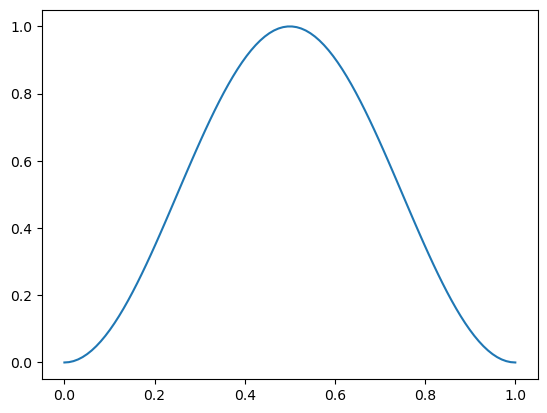

In [184]:
# define nice cosine function to evolve 
def f(x):
    return -0.5 * np.cos(2 * np.pi * x) + .5

xs = np.linspace(0, 1, 100)
ys = f(xs)
# plot 
plt.plot(xs, ys)

In [185]:
# build numerical derivative
y_next = np.zeros(ys.shape)
dt = 0.01
dx = 1/ len(xs)
for i in range(1, len(ys)):
    y_next[i] = (1 - dt / dx) * ys[i] + dt / dx * ys[i-1]
y_next[0] = y_next[-1] # boundary conditions


In [211]:
def num_step(ys, dt, nsteps = 1):
    """integrate function forward in time with specified time step, dt, and a number of steps, nsteps."""
    nsteps -=1 
    y_next = np.zeros(ys.shape)
    dx = 1/ len(xs)
    for i in range(1, len(ys)):
        y_next[i] = (1 - dt / dx) * ys[i] + dt / dx * ys[i-1]
    y_next[0] = y_next[-1] # boundary conditions
    # recursive call for nsteps
    if nsteps > 0:
        return num_step(y_next, dt, nsteps)
    else:
        return y_next

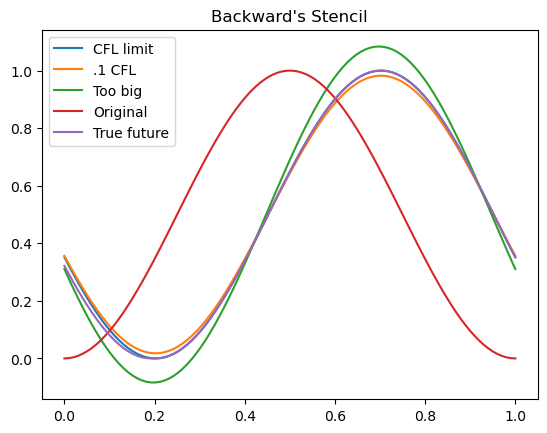

In [218]:
plt.plot(xs, num_step(ys, 0.01, 20), label="CFL limit")
plt.plot(xs, num_step(ys, 0.001, 200), label=".1 CFL")

plt.plot(xs, num_step(ys, 0.05, 4), label="Too big")

plt.plot(xs, ys, label = "Original")
plt.plot(xs, np.roll(ys, 20), label="True future")
plt.title("Backward's Stencil")
plt.legend()

In [215]:
print(max(num_step(ys, 0.01, 20)))
print(max(num_step(ys, 0.05, 4)))


0.9997482711915926
1.083773946116752


## Code specific example of ML stability 
For our linear update problem we have the following prediction step and data. Given pairs $\{(x_i, y_i)\}_{i=1}^N;\;x_i, y_i \in \mathbb{R}^M$ we define our prediction step
$$ y_i = Ax_i $$
where:
$$A = \begin{bmatrix}
b & a & 0 & \dotsb& 0 \\
0 & b & a & \dotsb &0\\
\vdots & \vdots & \vdots & \vdots \\
0 & \dotsb & 0  & b & a
\end{bmatrix} \in \mathbb{R}^{(M-1)\times M}$$
Here we note that we will ignore the loss of the first entry because since the domain repeats we'd otherwise double count the loss. For this problem let's minimize the L2 loss of the update rule 
\begin{align}
\min_{a,b} || y_i - Ax_i || \rightarrow \min_{a,b}& \sum_{i=1}^N \sum_{j=1}^M \big(y_{i,j}-(Ax_i)_j\big)^2 \\
\min_{a,b}& \sum_{i=1}^N \sum_{j=2}^M \left( y_j - bx_{j-1} - ax_j \right)^2
\end{align}
The second expression on the first row is not quite indexed correctly but should give the idea 

So $Ax$ for a given $x$ looks like
\begin{align}
\begin{bmatrix}
bx_1+ax_2 \\
bx_2+ax_3 \\
\vdots \\
bx_{M-1}+ax_M
\end{bmatrix} \in \mathbb{R}^{M-1}
\end{align}
noting again that $x_1=x_M$ 

As this is a least squares problem we expand the expression to develop an exact solution to the minimization problem, getting equations for $a,b$. We do so as follows 
\begin{align}
F &= \sum_{i=1}^N \sum_{j=2}^M \left( y_{i,j} - bx_{i,j-1} - ax_{i,j} \right)^2 \\
\frac{dF}{da} &= \sum_{i,j} \frac{d}{da} (y_{i,j}-bx_{i,j-1}-ax_{i,j})^2 \\
&= -\sum_{i,j} 2 (y_{i,j} - bx_{i,j-1}-ax_{i,j}) x_{i,j} \\
\frac{dF}{db} &= \sum_{i,j} \frac{d}{db} (y_{i,j}-bx_{i,j-1}-ax_j)^2 \\
&= -\sum_{i,j} 2 (y_{i,j} - bx_{i,j-1}-ax_{i,j}) x_{i, j-1}
\end{align}


To solve we set both derivatives to zero (noting the second derivatives are squared terms and so necessarily negative, ensuring we are at at maxima). Expanding yeilds the following sum of terms: 
\begin{align}
(b): 0 &= \sum_{i,j} y_{i,j}x_{i,j-1} - b\sum_{i,j} x_{i,j-1}^2 - a\sum_{i,j} x_{i,j}x_{i,j-1} \\
(a): 0 &= \sum_{i,j}y_{i,j}x_{i,j} - b \sum_{i,j} x_{i,j-1}x_{i,j} - a \sum x_{i,j}^2
\end{align}
This is now a linear system we can solve. To simplify, we introduce the following abbreviations (A is abuse of notation - fix!): 
\begin{align}
A &= \sum_{i,j} x_{i,j-1}y_{i,j} \\
B &= \sum_{i,j} x_{i,j} x_{i,j-1} \\
C &= \sum_{i,j} x_{i,j-1}^2 \\
D &= \sum_{i,j} x_{i,j}y_{i,j} \\
E &= \sum_{i,j} x_{i,j}^2
\end{align}

airplane algebra mess (checks with board work)

\begin{align}
0 &= A - b C - a B \\
a &= (A-bC)/B \\
0 &= D - b B - a E \\
b &= (D-aE)/B \\

0 &= D - bB - (A-bC)E/B \\
&= BD - bB^2 -AE + bCE \\
&= BD-AE - b(B^2-CE) \\
\implies b &= \boxed{\frac{BD-AE}{B^2-CE}} \\

0 &= A- (D-aE)C/B - aB \\
&= AB - DC + aCE - aB^2 \\
&= AB - DC -a (B^2 - CE) \\
a &= \boxed{\frac{AB - DC}{B^2-CE}} \\

\end{align}

Thus our optimization becomes:

\begin{align}
a &= \frac{\sum_{i,j} x_{i,j-1}y_{i,j} \sum_{i,j} x_{i,j} x_{i,j-1} - \sum_{i,j} x_{i,j}y_{i,j} \sum_{i,j} x_{i,j-1}^2}{\left(\sum_{i,j} x_{i,j} x_{i,j-1} \right)^2 - \sum_{i,j} x_{i,j-1}^2 \sum_{i,j} x_{i,j}^2} \\
b &= \frac{\sum_{i,j} x_{i,j} x_{i,j-1} \sum_{i,j} x_{i,j}y_{i,j} - \sum_{i,j} x_{i,j-1}y_{i,j} \sum_{i,j} x_{i,j}^2}{\left(\sum_{i,j} x_{i,j} x_{i,j-1} \right)^2 - \sum_{i,j} x_{i,j-1}^2 \sum_{i,j} x_{i,j}^2}
\end{align}

# Generate test data

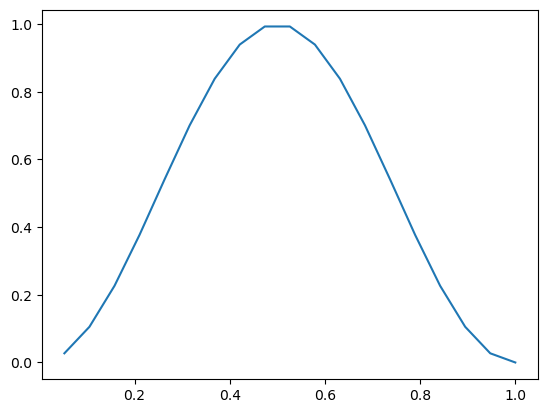

In [220]:
# define nice cosine function to evolve 
dx = 0.05
def f(x):
    return -0.5 * np.cos(2 * np.pi * x) + .5

xs = np.linspace(0, 1, int(1/dx))[1:]
ys = f(xs)
# plot 
plt.plot(xs, ys)

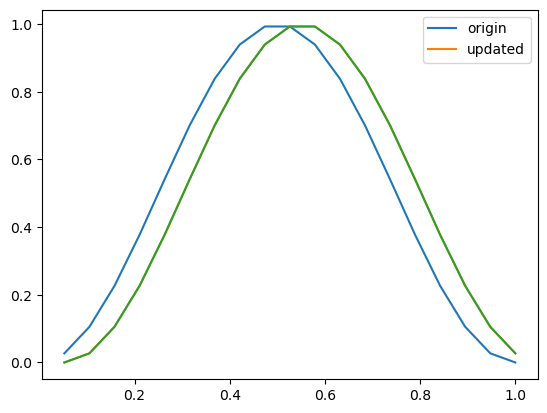

In [222]:
test = np.ones(len(xs))
test[1:] = ys[0:-1]
test[0] = ys[-1]
plt.plot(xs, ys, label = "origin")
plt.plot(xs, test, label = "updated")
plt.plot(xs, np.roll(ys, 1))
plt.legend()

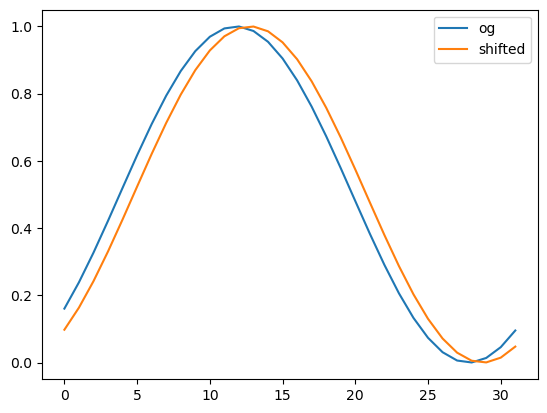

In [76]:
def gen_pair(offset = 0, dx = 0.05):
    sampling = np.linspace(0+offset, 1+offset, int(1/dx))[1:] % 1
    xs = f(sampling)
    ys = f(sampling - dx)
    return xs, ys 

tx, ty = gen_pair(.1, .03)

plt.plot(tx, label="og")
plt.plot(ty, label='shifted')
plt.legend()

In [164]:
# generate samples of training data 
num_samples = 100
dx = 0.05
rand_offsets = np.random.rand(num_samples)
x_ar, y_ar = [], []
for offset in rand_offsets:
    x, y = gen_pair(offset, dx = dx)
    x_ar.append(x) 
    y_ar.append(y)

x_ar = np.array(x_ar)
y_ar = np.array(y_ar)

\begin{align}
A &= \sum_{i,j} x_{i,j-1}y_{i,j} \\
B &= \sum_{i,j} x_{i,j} x_{i,j-1} \\
C &= \sum_{i,j} x_{i,j-1}^2 \\
D &= \sum_{i,j} x_{i,j}y_{i,j} \\
E &= \sum_{i,j} x_{i,j}^2
\end{align}

In [242]:
# define matrix shift function
def shift_x(x_ar):
    return np.roll(x_ar, 1, axis = 1)
    # x_ar_shifted = np.zeros(x_ar.shape)

    # x_ar_shifted[:, 1:] = x_ar[:, 0:-1]
    # x_ar_shifted[:, 0] = x_ar[:, -1]
    # return x_ar_shifted
x_ar_m1 = shift_x(x_ar)

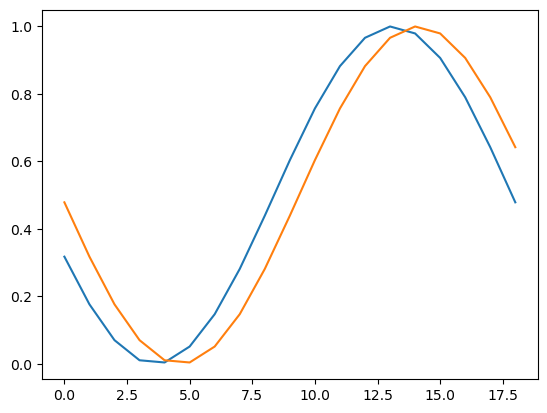

In [244]:
plt.plot(x_ar[0])
plt.plot(x_ar_m1[0])


In [245]:
# define terms 
E = np.sum(x_ar **2, axis=(0,1))
C=E
D = np.sum(x_ar * y_ar, axis=(0,1))
A = np.sum(shift_x(x_ar) * y_ar, axis=(0,1))
B = np.sum(shift_x(x_ar) * x_ar, axis = (0,1))

\begin{align}
a &= \boxed{\frac{AB - DC}{B^2-CE}} \\
b &= \boxed{\frac{BD-AE}{B^2-CE}}
\end{align}

In [246]:
a = ( A * B - D * C ) / ( B**2 - C * E )
b = ( B * D - A * C ) / ( B**2 - C * E ) 
print(a,b)

0.05003868679698027 0.9508194928912905


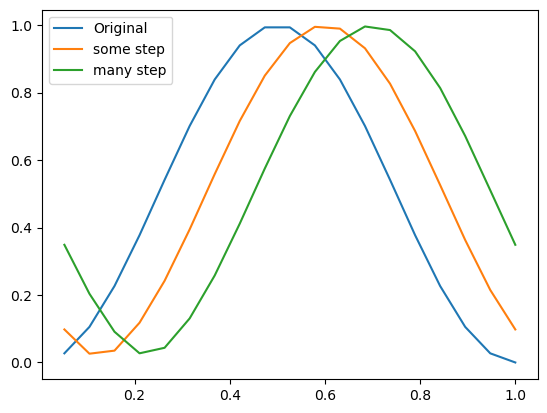

In [250]:
# compare long-term stability to numerical method
def step_trained_ml(ys, a, b, nsteps = 1):
    """integrate function forward in time with specified time step, learned a and b, and a number of steps, nsteps."""
    nsteps -=1 
    y_next = np.zeros(ys.shape)
    for i in range(1, len(ys)):
        y_next[i] = a * ys[i] + b * ys[i-1]
    y_next[0] = y_next[-1] # boundary conditions
    # recursive call for nsteps
    if nsteps > 0:
        return step_trained_ml(y_next, a, b, nsteps)
    else:
        return y_next
    

plt.plot(xs, ys, label = "Original")
plt.plot(xs, step_trained_ml(ys, a, b, nsteps = 2), label="some step")
plt.plot(xs, step_trained_ml(ys, a, b, nsteps = 4), label="many step")

plt.legend()

# Formulate as Class

In [268]:
class LinearModel:
    def __init__(self, dx: float, n_samples: int):
        self.dx = dx 
        self.n_samples = n_samples

    def __gen_pair__(self, offset):
        sampling = np.linspace(0+offset, 1+offset, int(1/self.dx))[1:] % 1
        xs = f(sampling)
        ys = f(sampling - self.dx)
        return xs, ys 
    
    def fit(self):
        # randomly generate data and store for observation
        rand_offsets = np.random.rand(self.n_samples)
        x_ar, y_ar = [], []

        for offset in rand_offsets:
            x, y = self.__gen_pair__(offset)
            x_ar.append(x) 
            y_ar.append(y)

        # store data for inspection afterwards
        self.x_ar = np.array(x_ar)
        self.y_ar = np.array(y_ar)
        self.x_ar_shift = np.roll(x_ar, 1, axis = 1)

        # compute terms 
        E = np.sum(self.x_ar **2, axis=(0,1))
        C=E
        D = np.sum(self.x_ar * self.y_ar, axis=(0,1))
        A = np.sum(self.x_ar_shift * self.y_ar, axis=(0,1))
        B = np.sum(self.x_ar_shift * self.x_ar, axis = (0,1))
    
        # store coefficients
        self.a = ( A * B - D * C ) / ( B**2 - C * E )
        self.b = ( B * D - A * C ) / ( B**2 - C * E ) 

    def step_trained(self, ys, nsteps):
        """integrate function forward in time with specified time step, learned a and b, and a number of steps, nsteps."""
        y_next = np.zeros(ys.shape)
        if nsteps > 0:
            for i in range(1, len(ys)):
                y_next[i] = self.a * ys[i] + self.b * ys[i-1]
            y_next[0] = y_next[-1] # boundary conditions
            return self.step_trained(y_next, nsteps-1)
        else:
            return ys

In [301]:
def num_model(ys, dt, nsteps = 1):
    """integrate function forward in time with specified time step, dt, and a number of steps, nsteps."""
    y_next = np.zeros(ys.shape)
    dx = 1/ len(ys)
    # recursive call for nsteps
    if nsteps > 0:
        for i in range(1, len(ys)):
            y_next[i] = (1 - dt / dx) * ys[i] + dt / dx * ys[i-1]
        y_next[0] = y_next[-1] # boundary conditions
        return num_step(y_next, dt, nsteps-1)
    else:
        return ys
# plt.plot(num_model(starting_y, 0.01, 0))
# plt.plot(num_model(starting_y, 0.01, 99))

0.010000065132067335 0.99000657885684


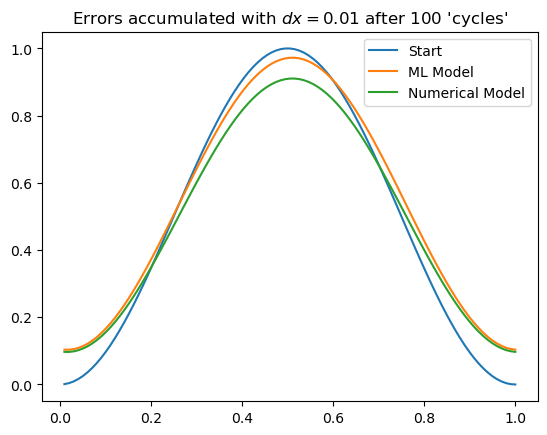

In [343]:
dx = 0.01
test = LinearModel(dx = dx, n_samples=100)
test.fit()
xs = np.linspace(0, 1, int(1/dx))[1:]
starting_y = f(xs)
plt.plot(xs, starting_y, label="Start")
plt.plot(xs, test.step_trained(starting_y, 99*100), label="ML Model")
plt.plot(xs, num_model(starting_y, 0.01, 99*100), label = "Numerical Model")
plt.title(f"Errors accumulated with $dx = ${dx:.2g} after 100 \'cycles\'")
plt.legend();
print(test.a, test.b);

In [308]:
# calculate RMSE for both cases
ml_rmse = np.sqrt(np.sum((starting_y - test.step_trained(starting_y, 99*100))**2))
num_rmse = np.sqrt(np.sum((starting_y - num_model(starting_y, 0.01, 99*100))**2))
print(f"RMSE Error: {ml_rmse:.2g} for ML model and {num_rmse:.2g} for numerical model")

RMSE Error: 0.61 for ML model and 0.68 for numerical model


0.05003868679698027 0.9508194928912905


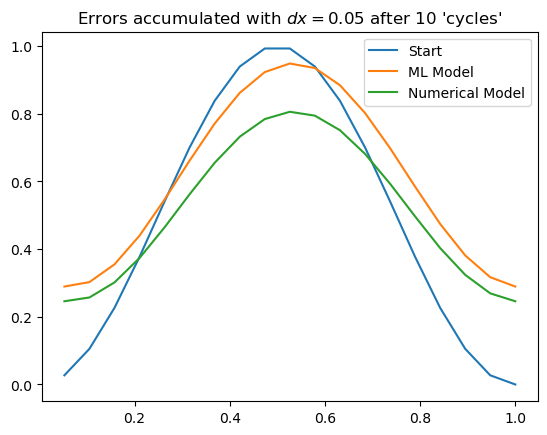

In [345]:
dx = 0.05
test = LinearModel(dx = dx, n_samples=100)
test.fit()
xs = np.linspace(0, 1, int(1/dx))[1:]
starting_y = f(xs)
plt.plot(xs, starting_y, label="Start")
n_steps = 19 * 10
plt.plot(xs, test.step_trained(starting_y, n_steps), label="ML Model")
plt.plot(xs, num_model(starting_y, dx, n_steps), label = "Numerical Model")
plt.title(f"Errors accumulated with $dx = ${dx:.2g} after 10 \'cycles\'")

plt.legend();
print(test.a, test.b)

In [327]:
ml_rmse = np.sqrt(np.sum((starting_y - test.step_trained(starting_y, 19*10))**2))
num_rmse = np.sqrt(np.sum((starting_y - num_model(starting_y, 0.01, 19*10))**2))
print(f"RMSE Error: {ml_rmse:.2f} for ML model and {num_rmse:.2f} for numerical model")

RMSE Error: 0.73 for ML model and 1.29 for numerical model


0.10056025662282247 0.9064699704098819


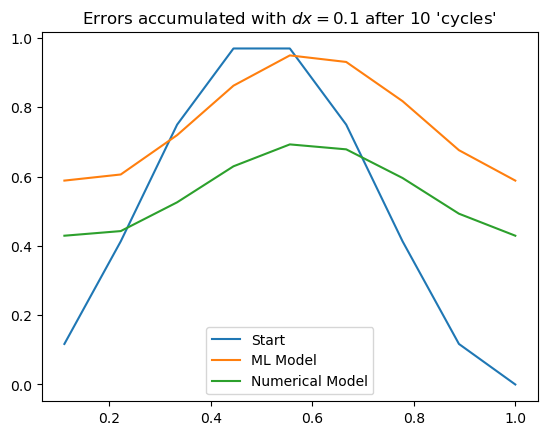

In [346]:
dx = 0.1
test = LinearModel(dx = dx, n_samples=100)
test.fit()
xs = np.linspace(0, 1, int(1/dx))[1:]
starting_y = f(xs)
plt.plot(xs, starting_y, label="Start")
plt.plot(xs, test.step_trained(starting_y, 9*5), label="ML Model")
plt.plot(xs, num_model(starting_y, dx, 9*5), label = "Numerical Model")
plt.title(f"Errors accumulated with $dx = ${dx:.2g} after 10 \'cycles\'")

plt.legend();
print(test.a, test.b)

In [332]:
ml_rmse = np.sqrt(np.sum((starting_y - test.step_trained(starting_y, 19*10))**2))
num_rmse = np.sqrt(np.sum((starting_y - num_model(starting_y, 0.01, 19*10))**2))
print(f"RMSE Error: {ml_rmse:.2f} for ML model and {num_rmse:.2f} for numerical model")

RMSE Error: 4.99 for ML model and 1.06 for numerical model


0.10056025662282247 0.9064699704098819


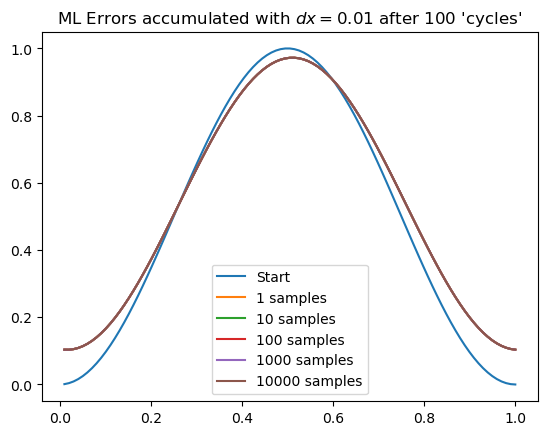

In [347]:
dx = 0.01
xs = np.linspace(0, 1, int(1/dx))[1:]
starting_y = f(xs)
plt.plot(xs, starting_y, label="Start")

for n_data in [1, 10, 100, 1000, 10000]:
    model = LinearModel(dx = dx, n_samples = n_data)
    model.fit()
    
    plt.plot(xs, model.step_trained(starting_y, 99*100), label=f"{n_data} samples")
plt.title(f"ML Errors accumulated with $dx = ${dx:.2g} after 100 \'cycles\'")
plt.legend();
print(test.a, test.b);

# Implement higher order stencils
To introduce higher order stencils we approximate the spatial derivative of the advection equation with a general matrix operator:
\begin{align}
    \frac{du}{dt} + A u &= 0
\end{align}
Discretizing the spatial domain we get the following update equation for element $u_i$:
\begin{align}
    0 &= \frac{u_i^{n+1} - u_i^n}{\Delta t}+ \frac{1}{\Delta x} (Au^n)_i  \\
    u_i^{n+1} &= u_i^n - \frac{\Delta t}{\Delta x} (Au^n)_i
\end{align}

Recall our coefficients for the backwards stencil in 1st order accuracy case are $[1,-1]$ which gives us the update equation:
\begin{align}
    u_i^{n+1} &= u_i^n - \frac{\Delta t}{\Delta x} (u_i^n -u_{i-1}^n)
\end{align}
We could derive the remaining stencil points by inverting the vandermonde matrix but it's easier to read the coefficients directly for higher order backwards stencils from [wikipedia](https://en.wikipedia.org/wiki/Finite_difference_coefficient). For example, the coefficients for the 3rd order backwards stencil are $[3/2, -2, 1/2]$. Thus our 2nd order accuracy update rule becomes: 
\begin{align}
    u_i^{n+1} &= u_i^n - \frac{\Delta t}{\Delta x} (3/2 u_i^n -2u_{i-1}^n +1/2 u_{i-2}^n)
\end{align}
Below we implement the first 6-order accuracy stencils. For some reason, none except the first one are stable - perhaps I'm missing something in the math, the implementation, or... My guess is that there's something wrong with the boundary conditions.

Plan now is to make sure to fuse the ends of the stencil together (e.g. delete the point at the end) and then can check the convergence order to see how fast the error drops. do for multiple powers of dx and compute RMSE of the error. As the stencil order increases the slope should decrease. You've made a mistake if they are not linear. We should be testing the update rule of the entire matrix $I-CFL \cdot A$ since that is what updates $u^n$ to $u^{n+1}$

In [158]:
from wave_solvers import solver, make_matrix, num_step
import numpy as np
import matplotlib.pyplot as plt
def f_gauss(x, t=0):
    func = np.exp(10*np.sin(np.pi * (x-t))**2) - 1
    return func / np.max(func)

# Define training parameters
dt = 0.0005
nsteps = 100
rollout = 50 # number of time steps forward to use in training
dx = 0.01
nx = int(1/dx + 1)
stencil = 6 # stencil width (upwind)
x = np.arange(0, 1+dx/2, dx)

f= f_gauss

def make_ho_matrix(params, nx, cfl = dt/dx):
    A = np.eye(nx)
    for ind, param in enumerate(params):
        A += - param * cfl * np.eye(nx, k=-ind)
        # for all subdiagonals wrap domain
        if ind > 0:
            #pass
            A += - param * cfl * np.eye(nx, k=nx-ind)
    return A


def num_ho_step(ys, dt, params, nsteps, all_steps=True):
   dx = 1/(len(ys)-1)
   #params = np.array([1 - dt / dx, dt/dx])
   A = make_ho_matrix(params, len(ys), dt/dx)
   # print(A)
   sol = solver(A, ys, nsteps, stencil=2, all_steps=all_steps)
   return sol

(101, 2001)
(101, 2001)
(101, 2001)
(101, 2001)
(101, 2001)
(101, 2001)


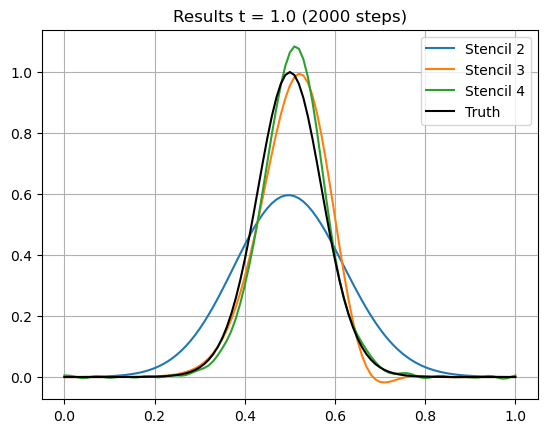

In [169]:
num_steps_test = 2000
# stencil params
params2 = [1, -1]
params3 = [3/2, -2, 1/2]
params4 = [11/6, -3, 3/2, -1/3]
params5 = [25/12, -4, 3, -4/3, 1/4]
params6 = [137/60, -5, 5, -10/3, 5/4, -1/5]
params7 = [49/20, -6, 15/2, -20/3, 15/4, -6/5, 1/6]

# ml_result = ml_step(f(x), num_steps_test, params, stencil, all_steps=False)
num_result_2 = num_ho_step(f(x), dt, params2, num_steps_test, all_steps=False)
num_result_3 = num_ho_step(f(x), dt, params3, num_steps_test, all_steps = False)
num_result_4 = num_ho_step(f(x), dt, params4, num_steps_test, all_steps = False)
num_result_5 = num_ho_step(f(x), dt, params5, num_steps_test, all_steps = False)
num_result_6 = num_ho_step(f(x), dt, params6, num_steps_test, all_steps = False)
num_result_7 = num_ho_step(f(x), dt, params7, num_steps_test, all_steps = False)

# num_result2 = num_step(f(x), dt, num_steps_test, all_steps=False)

data_result = f(x, dt*num_steps_test)

plt.plot(x, num_result_2, label = "Stencil 2")
plt.plot(x, num_result_3, label='Stencil 3')
plt.plot(x, num_result_4, label = "Stencil 4")
#plt.plot(x, num_result_5, label = "Stencil 5")
#plt.plot(x, num_result_6, label = "Stencil 6")
#plt.plot(x, num_result_7, label = "Stencil 7")


# plt.plot(x, ml_result, label='ML (LR)')
plt.plot(x, data_result, c='black', label='Truth')
plt.title(f'Results t = {dt*num_steps_test} ({num_steps_test} steps)')
plt.legend()
plt.grid()

In [174]:
print(dt/dx)

def make_ho_matrix(params, nx, cfl = dt/dx):
    A = np.eye(nx)
    for ind, param in enumerate(params):
        A += - param * cfl * np.eye(nx, k=-ind)
        # for all subdiagonals wrap domain
        if ind > 0:
            #pass
            A += - param * cfl * np.eye(nx, k=nx-ind)
    return A

mat = make_ho_matrix(params2, 10, dt/dx)
print(mat)
np.real(np.linalg.eig(mat).eigenvalues)

0.05
[[0.95 0.   0.   0.   0.   0.   0.   0.   0.   0.05]
 [0.05 0.95 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.05 0.95 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.05 0.95 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.05 0.95 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.05 0.95 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.95 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.05 0.95 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.05 0.95 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.95]]


array([0.9       , 0.90954915, 0.90954915, 0.93454915, 0.93454915,
       0.96545085, 0.96545085, 1.        , 0.99045085, 0.99045085])

In [76]:
params = [3/2, -2, 1/2]
CFL = .1#dt/dx
nx = 6
A = np.eye(nx)
for ind, param in enumerate(params):
    A += - param * CFL * np.eye(nx, k=-ind)
    # for all subdiagonals wrap domain
    A += - param * CFL * np.eye(nx, k=nx-ind)

A

array([[ 0.85,  0.  ,  0.  ,  0.  , -0.05,  0.2 ],
       [ 0.2 ,  0.85,  0.  ,  0.  ,  0.  , -0.05],
       [-0.05,  0.2 ,  0.85,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.05,  0.2 ,  0.85,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.05,  0.2 ,  0.85,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.05,  0.2 ,  0.85]])

In [82]:



# num_result = num_step(f(x), dt, num_steps_test, all_steps=False)


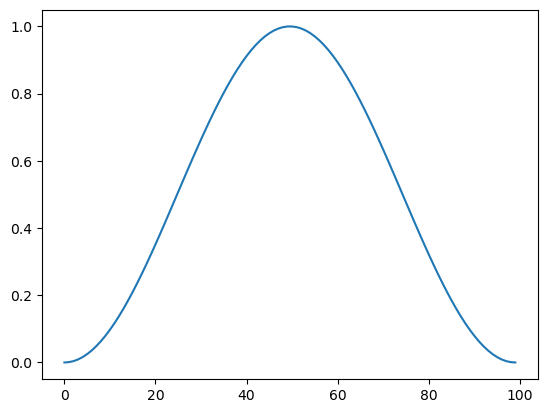

In [81]:
plt.plot(f(np.linspace(0,1,100)))